<a href="https://colab.research.google.com/github/Kussil/CVX_Rice_project/blob/main/04_Stock_Modeling/Stock_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q ipympl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.5 MB/s eta 0:00:00


In [2]:
from google.colab import output
import textwrap
output.enable_custom_widget_manager()

In [48]:
!rm -rf /content/CVX_Rice_project/

In [3]:
# Import github token with google secrets thingy and clone git repository
import os
from google.colab import userdata
GITHUB_TOKEN = userdata.get('github')
os.environ['GITHUB_TOKEN'] = GITHUB_TOKEN
!git clone https://{GITHUB_TOKEN}@github.com/Kussil/CVX_Rice_project.git

Cloning into 'CVX_Rice_project'...
remote: Enumerating objects: 1460, done.
remote: Counting objects: 100% (449/449), done.
remote: Compressing objects: 100% (220/220), done.
remote: Total 1460 (delta 238), reused 424 (delta 221), pack-reused 1011
Receiving objects: 100% (1460/1460), 173.07 MiB | 8.37 MiB/s, done.
Resolving deltas: 100% (829/829), done.
Updating files: 100% (1074/1074), done.


In [5]:
import pandas as pd
df_chunk = pd.read_csv('/content/CVX_Rice_project/03_Sentiment_Analysis/sentiment_chunkdata.csv')
df = pd.read_csv('/content/CVX_Rice_project/03_Sentiment_Analysis/sentiment_data.csv')

In [6]:
df

,Unnamed: 0,Source,Unique_ID,Ticker,Date,Article Headline,Article Text,URL,Article Index,Neutral,Positive,Negative
0,0,Investment Research,NaN,MRO,2024-05-16,Marathon Oil Corporation,"Stock Report | May 16, 2024 | NYSESymbol: MRO ...",NaN,0,0.143564,0.413686,0.442750
1,1,Investment Research,NaN,EOG,2024-05-14,"EOG Resources, Inc.","Stock Report | May 14, 2024 | NYSESymbol: EOG ...",NaN,1,0.164021,0.042301,0.793678
2,2,Investment Research,NaN,EOG,2024-05-11,"EOG Resources, Inc.","Stock Report | May 11, 2024 | NYSESymbol: EOG ...",NaN,2,0.138396,0.089975,0.771630
3,3,Investment Research,NaN,DVN,2024-05-11,Devon Energy Corporation,"Stock Report | May 11, 2024 | NYSESymbol: DVN ...",NaN,3,0.047985,0.468556,0.483459
4,4,Investment Research,NaN,COP,2024-05-07,ConocoPhillips,"Stock Report | May 07, 2024 | NYSESymbol: COP ...",NaN,4,0.266491,0.181206,0.552303
...,...,...,...,...,...,...,...,...,...,...,...,...
8599,8599,ProQuest,2.238654e+09,PSX,2019-06-12,"As the Price of Gas Tumbles, Even California I...",Gasoline prices have been falling fast in rece...,https://www.proquest.com/newspapers/as-price-g...,8599,0.024151,0.501878,0.473971
8600,8600,ProQuest,2.239478e+09,PSX,2019-06-10,"Phillips 66, Plains plan pipeline system",CUSHING Phillips 66 and Plains All American Pi...,https://www.proquest.com/newspapers/phillips-6...,8600,0.097232,0.011336,0.891432
8601,8601,ProQuest,2.238860e+09,PSX,2019-06-07,Autonomous robot inspects in-service diesel st...,"HOUSTON Phillips 66, Square Robot Inc. and Ver...",https://www.proquest.com/newspapers/autonomous...,8601,0.495722,0.008984,0.495294
8602,8602,ProQuest,2.233474e+09,PSX,2019-06-03,United States/Mexico: Report: Trump's Tariff o...,US President Donald Trump's threats to tax Mex...,https://www.proquest.com/newspapers/united-sta...,8602,0.098247,0.857687,0.044066


In [7]:
df.drop(df[df['Ticker'] == 'BP.'].index, inplace=True)
df.drop(df[df['Ticker'] == 'Concho Resources Inc.'].index, inplace=True)
df.drop(df[df['Ticker'] == 'PDCE'].index, inplace=True)
df.drop(df[df['Ticker'] == 'TTL'].index, inplace=True)
df.drop(df[df['Ticker'] == 'CXO'].index, inplace=True)
ticker_list = df['Ticker'].unique().tolist()
ticker_list

['MRO',
 'EOG',
 'DVN',
 'COP',
 'PXD',
 'CVX',
 'MPC',
 'HES',
 'PSX',
 'XOM',
 'SHEL',
 'BP',
 'OXY',
 'VLO',
 'TTE',
 'EQNR']

In [8]:
min_date = df['Date'].min()
min_date

'2019-02-01'

In [9]:
import yfinance as yf
ticker = ticker_list#ticker_list
price = yf.download(ticker, start=min_date)["Adj Close"]
ret = price.pct_change().dropna()
ret.name = "ret"
ret.describe()

[*********************100%%**********************]  16 of 16 completed


Ticker,BP,COP,CVX,DVN,EOG,EQNR,HES,MPC,MRO,OXY,PSX,PXD,SHEL,TTE,VLO,XOM
count,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000
mean,0.000403,0.000922,0.000635,0.001326,0.000786,0.000709,0.001285,0.001328,0.001098,0.000817,0.000821,0.001102,0.000528,0.000668,0.001097,0.000727
std,0.023097,0.027419,0.021811,0.036621,0.029612,0.024058,0.030633,0.029384,0.036314,0.038757,0.026088,0.029156,0.022766,0.021179,0.029800,0.021087
min,-0.191040,-0.248401,-0.221248,-0.373972,-0.320072,-0.210562,-0.336685,-0.270089,-0.468521,-0.520138,-0.158658,-0.369197,-0.171722,-0.178208,-0.192209,-0.122248
25%,-0.010161,-0.011789,-0.008515,-0.016794,-0.014391,-0.011597,-0.014420,-0.012327,-0.017094,-0.015280,-0.010683,-0.013549,-0.009789,-0.009703,-0.012719,-0.010374
50%,0.000000,0.000000,0.000739,0.000448,-0.000201,0.000000,0.001096,0.001808,0.000580,-0.000176,0.000780,0.000251,0.000497,0.001354,0.000373,0.000291
75%,0.009879,0.014072,0.009532,0.017649,0.014899,0.013615,0.015254,0.015124,0.017452,0.015178,0.013801,0.014194,0.010820,0.010481,0.015822,0.011278
max,0.216053,0.252138,0.227407,0.210721,0.165702,0.133043,0.203153,0.206286,0.232445,0.336977,0.221722,0.204343,0.196795,0.152756,0.312025,0.126868


In [10]:
# add overall article sentiment
df_2 = df
df_2['Sentiment'] = df_2[['Neutral', 'Positive', 'Negative']].idxmax(axis=1)

# aggregate by ticker and date
df_grouped = df_2.groupby(['Ticker', 'Date']).agg(
    article_count=('Article Headline', 'size'),
    neutral_count=('Sentiment', lambda x: (x == 'Neutral').sum()),
    positive_count=('Sentiment', lambda x: (x == 'Positive').sum()),
    negative_count=('Sentiment', lambda x: (x == 'Negative').sum()),
    neutral_avg=('Neutral','mean'),
    positive_avg=('Positive','mean'),
    negative_avg=('Negative','mean'),
).reset_index()
df_grouped['Date String'] = df_grouped['Date'].astype(str)

# reshape ret same day
ret2 = ret.stack().reset_index()
ret2.columns = ['Date', 'Ticker', 'Returns']
ret2['Date'] = pd.to_datetime(ret2['Date'], format='mixed')
ret2['Date']= pd.to_datetime(ret2['Date']).dt.date
ret2['Date String']= ret2['Date'].astype(str)
ret2.drop(columns=['Date'], inplace=True)

# merge in returns for the day from YahooFinance
df_merged = pd.merge(df_grouped, ret2, on=['Ticker', 'Date String'], how='left')
df_merged.drop(columns=['Date String'], inplace=True)
df_merged = df_merged.sort_values(['Ticker', 'Date'])
# Fill NaN values with the next day's value within the same 'Ticker'
df_merged['Returns (no NaN)'] = df_merged.groupby('Ticker')['Returns'].fillna(method='bfill')
df_merged['Returns Next Day'] = df_merged.groupby('Ticker')['Returns'].shift(-1)
df_merged['Returns Next Day(no NaN)'] = df_merged.groupby('Ticker')['Returns Next Day'].fillna(method='bfill')
df_merged['Returns Next Day(no NaN)'] = df_merged['Returns Next Day(no NaN)'].fillna(df_merged['Returns (no NaN)'])
df_merged['Pos Ratio'] = df_merged['positive_avg']/df_merged['article_count']
df_merged

,Ticker,Date,article_count,neutral_count,positive_count,negative_count,neutral_avg,positive_avg,negative_avg,Returns,Returns (no NaN),Returns Next Day,Returns Next Day(no NaN),Pos Ratio
0,BP,2019-02-20,1,1,0,0,0.360758,0.294953,0.344289,0.002359,0.002359,-0.003482,-0.003482,0.294953
1,BP,2019-05-06,1,0,1,0,0.037869,0.626881,0.335249,-0.003482,-0.003482,-0.009591,-0.009591,0.626881
2,BP,2019-05-22,2,0,0,2,0.088732,0.208070,0.703198,-0.009591,-0.009591,-0.023618,-0.023618,0.104035
3,BP,2019-05-23,1,0,0,1,0.181391,0.017759,0.800849,-0.023618,-0.023618,-0.007556,-0.007556,0.017759
4,BP,2019-05-31,1,0,0,1,0.135504,0.025621,0.838875,-0.007556,-0.007556,0.006179,0.006179,0.025621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6354,XOM,2024-05-07,1,0,1,0,0.031351,0.580889,0.387760,-0.004968,-0.004968,0.019716,0.019716,0.580889
6355,XOM,2024-05-09,1,0,0,1,0.188977,0.233985,0.577038,0.019716,0.019716,-0.004053,-0.004053,0.233985
6356,XOM,2024-05-10,2,0,1,1,0.100749,0.556811,0.342440,-0.004053,-0.004053,NaN,0.015017,0.278406
6357,XOM,2024-05-11,1,0,0,1,0.172088,0.253665,0.574246,NaN,0.015017,0.015017,0.015017,0.253665


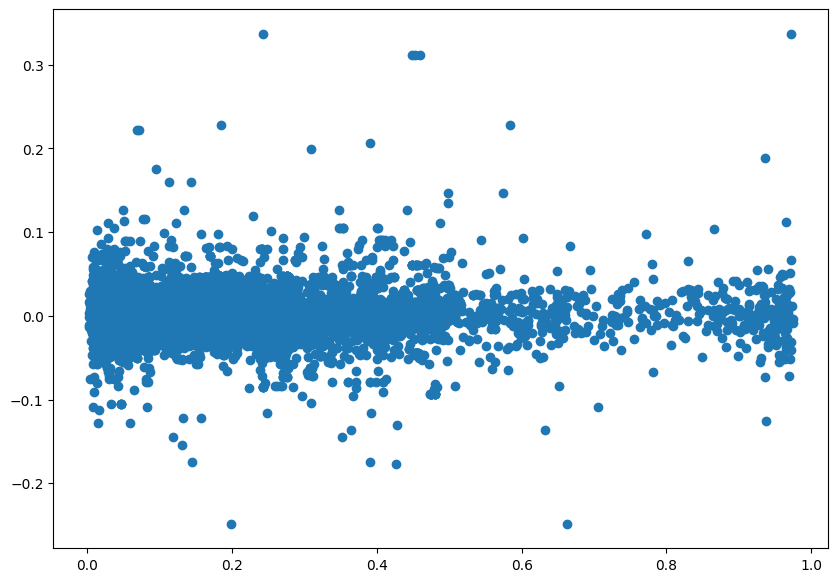

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize =(10, 7))
# Creating plot
plt.scatter(df_merged['Pos Ratio'],df_merged['Returns Next Day(no NaN)'])
# show plot
plt.show()

In [17]:
# save csv locally
df_merged.to_csv('/content/sample_data/sent_stock_data.csv', index=False)
#Copy CSV to GitHub Repository
!cp /content/sample_data/sent_stock_data.csv /content/CVX_Rice_project/04_Stock_Modeling/
#Commit and Push Changes
!git config --global user.email "bw58@rice.edu"
%cd /content/CVX_Rice_project/04_Stock_Modeling/
!git add sent_stock_data.csv
!git commit -m "Add sent_stock_data.csv"
!git push origin main

/content/CVX_Rice_project/04_Stock_Modeling
[main ffa120e] Add sent_stock_data.csv
 1 file changed, 6360 insertions(+), 3349 deletions(-)
 rewrite 04_Stock_Modeling/sent_stock_data.csv (77%)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 273.00 KiB | 3.90 MiB/s, done.
Total 4 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/Kussil/CVX_Rice_project.git
   80183b3..ffa120e  main -> main


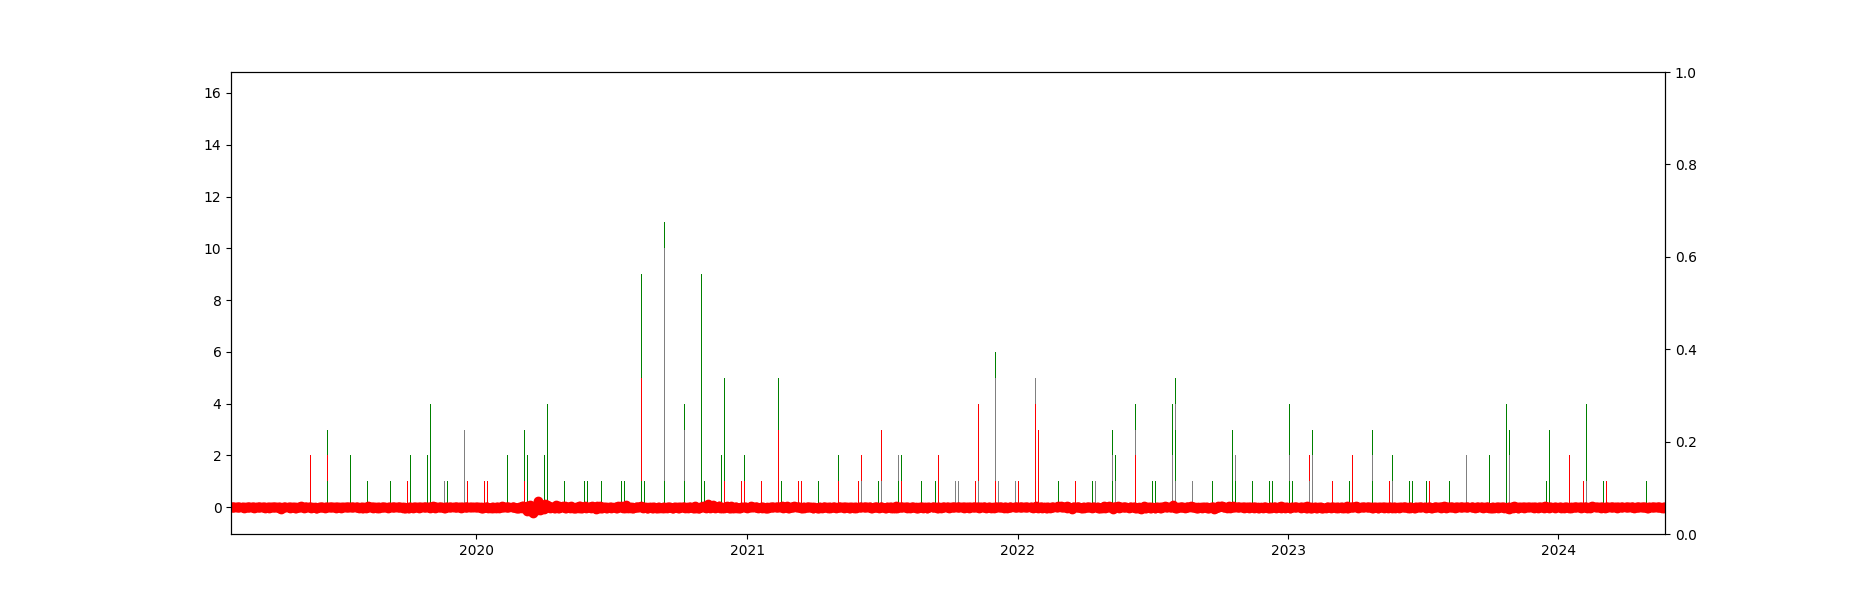

In [18]:
%matplotlib ipympl
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
import numpy as np
tz = pytz.timezone('America/New_York')

fig, ax1 = plt.subplots()
fig.set_size_inches(18.5, 6, forward=True)

tolerance = 2 # points

ax1.plot(ret.index, ret['CVX'], 'ro-', picker=tolerance)

#stacked bar
dates = df_merged['Date']
weights = {
    "Negative": df_merged['negative_count'].tolist(),
    "Neutral": df_merged['neutral_count'].tolist(),
    "Positive": df_merged['positive_count'].tolist()
}

colors = {
    "Negative": 'red',
    "Neutral": 'gray',
    "Positive": 'green'
}

ax2 = ax1.twinx()

width = 0.1
bottom = np.zeros(len(dates))

for sentiment, weight in weights.items():
  p = ax1.bar(dates, weight, width, label=sentiment, bottom=bottom, color=colors[sentiment])
  bottom += weight

ax1.set_xlim(left=ret.index.min(),right=ret.index.max())
ax2.set_xlim(left=ret.index.min(),right=ret.index.max())

def onclick(event):
    line = event.artist
    xdata, ydata = line.get_data()
    ind = event.ind
    datetime_obj  = xdata[ind][0].astype('datetime64[s]').astype(datetime)
    formatted_date = datetime_obj.strftime('%Y-%m-%d')
    print(formatted_date)
    #query = 'summarize the top news articles for chevron?'
    #top_results = 3
    #print(textwrap.fill(ask_vector_query(query, top_results, date=str(formatted_date), pinecone_index = "newsembedding3"), width=80))

#cid = fig.canvas.mpl_connect('button_press_event', onclick)
cid = fig.canvas.mpl_connect('pick_event', onclick)

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

In [69]:
df_dropna = df_merged.dropna()

In [70]:
X = df_dropna.drop(columns=['Date','Ticker','Returns','Returns (no NaN)', 'Returns Next Day', 'Returns Next Day(no NaN)'])
X

,article_count,neutral_count,positive_count,negative_count,neutral_avg,positive_avg,negative_avg,Pos Ratio
0,1,1,0,0,0.360758,0.294953,0.344289,0.294953
1,1,0,1,0,0.037869,0.626881,0.335249,0.626881
2,2,0,0,2,0.088732,0.208070,0.703198,0.104035
3,1,0,0,1,0.181391,0.017759,0.800849,0.017759
4,1,0,0,1,0.135504,0.025621,0.838875,0.025621
...,...,...,...,...,...,...,...,...
6349,1,0,1,0,0.362698,0.608635,0.028668,0.608635
6350,1,0,0,1,0.174696,0.257361,0.567943,0.257361
6351,2,0,2,0,0.028513,0.670798,0.300689,0.335399
6354,1,0,1,0,0.031351,0.580889,0.387760,0.580889


In [71]:
y = df_dropna['Returns (no NaN)'].apply(lambda x: 1 if x > 0.0 else 0)
y

0       1
1       0
2       0
3       0
4       0
       ..
6349    1
6350    0
6351    1
6354    0
6355    1
Name: Returns (no NaN), Length: 1400, dtype: int64

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'bootstrap': True, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Accuracy: 0.575
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.50      0.54       139
           1       0.57      0.65      0.61       141

    accuracy                           0.57       280
   macro avg       0.58      0.57      0.57       280
weighted avg       0.58      0.57      0.57       280

Index(['article_count', 'neutral_count', 'positive_count', 'negative_count',
       'neutral_avg', 'positive_avg', 'negative_avg', 'Pos Ratio'],
      dtype='object')
[0.02467952 0.0147779  0.01608122 0.02104343 0.22496795 0.22945418
 0.24319131 0.22580449]


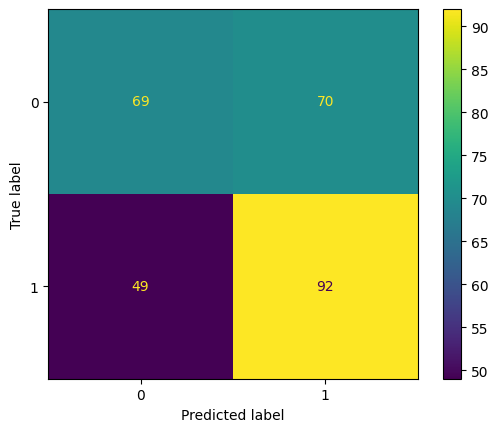

In [72]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid
#param_grid = {
#    'n_estimators': [100, 200, 300],
#    'max_depth': [None, 10, 20, 30],
#    'min_samples_split': [2, 5, 10],
#    'min_samples_leaf': [1, 2, 4],
#    'max_features': ['auto', 'sqrt', 'log2'],
#    'bootstrap': [True, False]
#}
param_grid = {
    'n_estimators': [100],
    'max_depth': [None],
    'min_samples_split': [10],
    'min_samples_leaf': [2],
    'max_features': ['log2'],
    'bootstrap': [True]
}

# Create a Random Forest classifier
rf_clf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Train the classifier on the training set
grid_search.fit(X_train, y_train)

# Output the best parameters
print(grid_search.best_params_)

# Use the best estimator for predictions
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(X.columns)
print(best_model.feature_importances_)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 0.8}
Accuracy: 0.575
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.51      0.54       139
           1       0.57      0.64      0.60       141

    accuracy                           0.57       280
   macro avg       0.58      0.57      0.57       280
weighted avg       0.58      0.57      0.57       280

Index(['article_count', 'neutral_count', 'positive_count', 'negative_count',
       'neutral_avg', 'positive_avg', 'negative_avg', 'Pos Ratio'],
      dtype='object')
[0.12924844 0.10924917 0.10516075 0.12184347 0.12655407 0.13551717
 0.13638479 0.13604212]


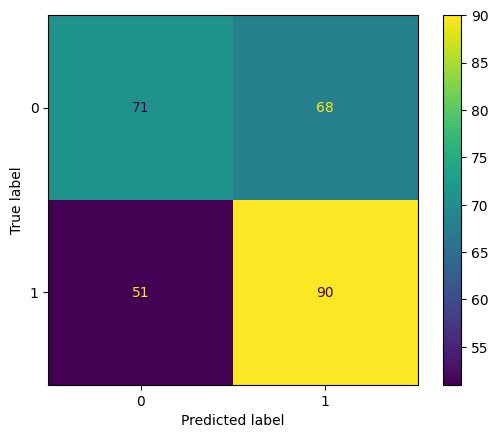

In [31]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
#param_grid = {
#    'n_estimators': [100, 200, 300],
#    'max_depth': [3, 6, 9],
#    'learning_rate': [0.01, 0.1, 0.2],
#    'subsample': [0.8, 1.0],
#    'colsample_bytree': [0.8, 1.0],
#    'gamma': [0, 0.1, 0.2],
#    'reg_alpha': [0, 0.1, 0.5],
#    'reg_lambda': [1, 1.5, 2]
#}

param_grid = {
    'colsample_bytree': [0.8],
    'gamma': [0.1],
    'learning_rate': [0.2],
    'max_depth': [6],
    'n_estimators': [100],
    'reg_alpha': [0],
    'reg_lambda': [2],
    'subsample': [0.8]
}

# Initialize the model
XGB = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=XGB, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the GridSearchCV to find the best parameters (assuming you have training data `X_train` and `y_train`)
grid_search.fit(X_train, y_train)

# Output the best parameters
print(grid_search.best_params_)

# Use the best estimator for predictions
best_model_XGB = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model_XGB.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(X.columns)
print(best_model_XGB.feature_importances_)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_model_XGB, X_test, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.49642857142857144
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.52      0.51       139
           1       0.50      0.48      0.49       141

    accuracy                           0.50       280
   macro avg       0.50      0.50      0.50       280
weighted avg       0.50      0.50      0.50       280



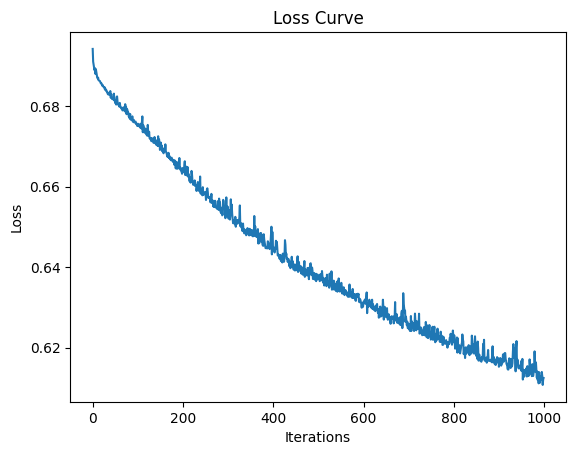

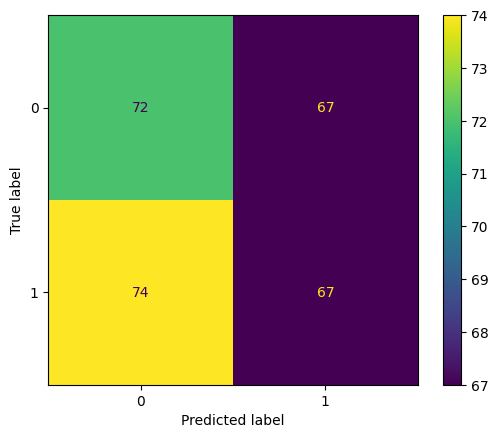

In [64]:
# Create an MLP classifier
mlp = MLPClassifier(
    hidden_layer_sizes=(100,100),
    max_iter=1000,
    solver='adam',
    random_state=42,
    learning_rate='constant',
    learning_rate_init=0.001,
    early_stopping=False,
    tol = 1e-8,
    n_iter_no_change = 100)


# Train the model
mlp.fit(X_train, y_train)

# Predict on test data
y_pred = mlp.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot the loss curve
plt.plot(mlp.loss_curve_)
plt.title("Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()


ConfusionMatrixDisplay.from_estimator(mlp, X_test, y_test)

Train Accuracy: 0.4901785714285714
Test Accuracy: 0.5214285714285715


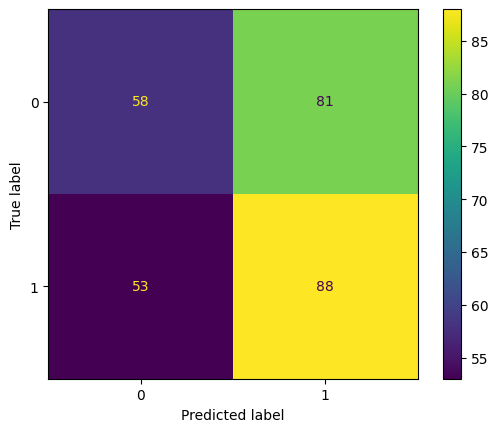

In [63]:
from sklearn.svm import SVC
import numpy as np
# Initialize lists to store training sizes and corresponding accuracies
training_sizes = np.linspace(0.1, 1.0, 10)
train_accuracies = []
test_accuracies = []

# Loop over different training set sizes
svm = SVC(kernel='sigmoid', random_state=42)
svm.fit(X_train, y_train)

# Predict on the training and test data
y_train_pred = svm.predict(X_train)
y_test_pred = svm.predict(X_test)

# Calculate accuracy for the training and test data
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print('Train Accuracy:',train_accuracy)
print('Test Accuracy:',test_accuracy)

ConfusionMatrixDisplay.from_estimator(svm, X_test, y_test)

In [26]:
params = rf_clf.get_params()
print(params)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
